### DQN
In this notebook the Deep Q-learning agent is developed.

In [1]:
import gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import retro
import sys
import time

from gym import wrappers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
project_dir = os.path.abspath('.')
sys.path.append(os.path.join(project_dir, 'sonic'))

In [3]:
from sonic import utils

In [4]:
n_cpu = os.cpu_count()
print(f"This notebook has access to {n_cpu} CPUs.")

This notebook has access to 4 CPUs.


In [5]:
config = {}
config['data_path'] = os.path.abspath("./data/human")
config['level'] = 'GreenHillZone.Act1'
config['epochs'] = 20
config['batches_per_epoch'] = 10
config['batch_size'] = 32
config['n_steps'] = 3
config['coef1'] = 1.
config['coef2'] = 1.
config['coef3'] = 0.
config['margin'] = 0.8
config['gamma'] = 0.99
config['update_freq'] = 25

In [6]:
states, actions, next_states, rewards, dones = utils.extract_human_data(f"data/human/SonicTheHedgehog-Genesis-{config['level']}-0000.bk2")

In [7]:
unique_actions, counts = np.unique(actions, axis=0, return_counts=True)

ordering = np.argsort(counts)[::-1]
unique_actions = unique_actions[ordering]
counts = counts[ordering]
print(unique_actions, counts)

n_actions = len(unique_actions)

[[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]] [1841  881  224  139   38   21   18   16    5    4    3    1]


In [8]:
print(f"Identified {len(counts)} unique actions of {2**12} possible.")

Identified 12 unique actions of 4096 possible.


In [9]:
import torch
import torch.autograd as autograd 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
def torch_td_loss(online_model, target_model, states, actions, 
                  next_states, rewards, dones, gamma=0.99):
    """ Compute the TD-error using pytorch for a set of transitions. """
    
    # Predict the value of the current and next state using the 
    # online and target networks respectively. 
    q_values = online_model(states)
    next_q_values = target_model(next_states)
    
    # Mask those states for which the next state is terminal.
    q_values = q_values.gather(1, actions.view(-1,1)).squeeze(1)
    next_q_values = next_q_values.max(1).values

    qhat = (rewards + gamma * next_q_values * (1 - dones))
    loss = (q_values - qhat.detach()).pow(2)
    loss = loss.mean()
    return loss

In [11]:
def torch_margin_loss(q_values, expert_actions, margin):
    """ Margin loss in torch. """
    
    # Calculate the margins and set them to zero where
    # expert has chosen action. 
    margins = torch.ones_like(q_values) * margin
    
    for i, action in enumerate(expert_actions):
        margins[i, action] = 0.
    
    loss_term1 = torch.max(q_values + margins, axis=1)[0]
    loss_term2 = torch.take(q_values, expert_actions)
    
    return loss_term1 - loss_term2

In [12]:
def torch_nstep_td_loss(online_model, target_model, actions, states, nth_states, 
                        discounted_rewards, dones, n, gamma):
    """ Calculate the n-step TD-loss using pytorch.  We assume that the discounted sum over
        rewards up to the n-th state has already been performed.  
    """
    
    # Predict the value of the current and next state using the 
    # online and target networks respectively. 
    q_values = online_model(states)
    nth_q_values = target_model(nth_states)
    
    # Mask those states for which the next state is terminal.
    q_values = q_values.gather(1, actions.view(-1,1)).squeeze(1)
    nth_q_values = nth_q_values.max(1).values

    qhat = (discounted_rewards + gamma**n * nth_q_values * (1 - dones))
    loss = (q_values - qhat.detach()).pow(2)
    loss = loss.mean()
    return loss

In [13]:
def torch_l2_penalty(parameters):
    
    loss = 0.
    for p in parameters:
        loss += torch.sum(p ** 2)
        
    return loss

In [14]:
def torch_dqfd_loss(online_model, target_model, states, next_states, nth_states, 
                    rewards, discounted_rewards, dones, gamma, n, coef1, coef2, coef3,
                    margin, expert_actions
                   ):
    """ Construct the full DQfD loss from the four component loss functions.
    """
    
    # Predict which action to take from the online network.
    q_values = online_model(states)
    actions = torch.argmax(q_values, axis=1)
    
    td_loss = torch_td_loss(
        online_model=online_model, 
        target_model=target_model, 
        actions=actions, states=states, 
        next_states=next_states, rewards=rewards, 
        dones=dones, gamma=gamma)
    
    ntd_loss = torch_nstep_td_loss(
        online_model=online_model, target_model=target_model, 
        actions=actions, states=states, 
        nth_states=nth_states, 
        discounted_rewards=discounted_rewards, 
        dones=dones, gamma=gamma, n=n)
    
    q_values = online_model(states)
    margin_loss = torch_margin_loss(q_values, expert_actions, margin)
    margin_loss = torch.mean(margin_loss)
    l2_loss = torch_l2_penalty(online_model.parameters())
    
    loss = td_loss + coef1 * ntd_loss + coef2 * margin_loss + coef3 * l2_loss
    
    return loss, td_loss, ntd_loss * coef1, margin_loss * coef2, l2_loss * coef3

In [15]:
encoding = {}

for i, action in enumerate(unique_actions):
    encoding[tuple(action)] = i

In [16]:
decoding = { value:key for key, value in encoding.items() }
print(decoding)

{0: (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0), 1: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 2: (0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0), 3: (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0), 4: (0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0), 5: (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 6: (0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0), 7: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), 8: (0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0), 9: (0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0), 10: (0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0), 11: (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)}


In [17]:
class SonicNet(nn.Module):
    """ A simple deep q-network architecture to be used for predicing 
        action-values from states.
    """
    
    def __init__(self, input_shape, output_shape):
        super(SonicNet, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        channels, height, width = self.input_shape
        self.features = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=3),
            nn.Conv2d(16, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=3),
            nn.ReLU()
        )
        
        self.value = nn.Sequential(
            nn.Linear(self._feature_size(), 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(self._feature_size(), 128),
            nn.ReLU(),
            nn.Linear(128, self.output_shape)
        )
        
    def _feature_size(self):
        """ I took this from somewhere. """
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        value = self.value(x)
        advantage = self.advantage(x)
        return value + advantage - advantage.mean()

In [18]:
online_model, target_model = SonicNet(states[0].shape, n_actions), SonicNet(states[0].shape, n_actions)

In [19]:
states, actions, next_states, rewards, dones = utils.extract_human_data(f"data/human/SonicTheHedgehog-Genesis-{config['level']}-0000.bk2")
_states, _actions, _next_states, _nth_states, _rewards, _discounted_rewards, _dones = utils.build_nstep_transitions(
    states, actions, next_states, rewards, dones, n=config['n_steps'], gamma=0.99)
_actions = utils.encode_actions(_actions, encoding)

_states = np.array(_states)
_actions = np.array(_actions)
_next_states = np.array(_next_states)
_nth_states = np.array(_nth_states)
_rewards = np.array(_rewards)
_discounted_rewards = np.array(_discounted_rewards)
_dones = np.array(_dones)

In [20]:
online_model = online_model.to(device='cuda:0')
target_model = target_model.to(device='cuda:0')
target_model.load_state_dict(online_model.state_dict())
optimizer = optim.Adam(online_model.parameters(), lr=1e-4)

In [21]:
n_epochs = config['epochs']
n_batches_per_epoch = config['batches_per_epoch']
batch_size = config['batch_size']
index_pool = np.arange(len(_states))

history = {}
loggables = ["loss", "td-loss", "ntd-loss", "margin-loss", "l2-loss"]
for loggable in loggables:
    history[loggable + "-mu"] = np.zeros(n_epochs)
    history[loggable + "-std"] = np.zeros(n_epochs)
    
for epoch in range(n_epochs):
    
    if epoch % config['update_freq'] == 0:
        target_model.load_state_dict(online_model.state_dict())

    
    epoch_loss = []
    epoch_td_loss, epoch_ntd_loss, epoch_margin_loss, epoch_l2_loss = [], [], [], []
    for batch in range(n_batches_per_epoch):
        
        # Generate a batch of transitions from the data pool.
        batch_indices = np.random.choice(index_pool, batch_size, replace=False)
        b_states = utils.torchify_float(_states[batch_indices]).to(device='cuda:0')
        b_actions = utils.torchify_long(_actions[batch_indices]).to(device='cuda:0')
        b_next_states = utils.torchify_float(_next_states[batch_indices]).to(device='cuda:0')
        b_nth_states = utils.torchify_float(_nth_states[batch_indices]).to(device='cuda:0')
        b_rewards = utils.torchify_float(_rewards[batch_indices]).to(device='cuda:0')
        b_discounted_rewards = utils.torchify_float(_discounted_rewards[batch_indices]).to(device='cuda:0')
        b_dones = utils.torchify_float(_dones[batch_indices]).to(device='cuda:0')
        
        optimizer.zero_grad()
        loss, td_loss, ntd_loss, margin_loss, l2_loss = torch_dqfd_loss(
            online_model=online_model,
            target_model=target_model,
            states=b_states,
            next_states=b_next_states, nth_states=b_nth_states,
            rewards=b_rewards, discounted_rewards=b_discounted_rewards,
            dones=b_dones, gamma=config['gamma'], n=config['n_steps'],
            coef1=config['coef1'], coef2=config['coef2'], coef3=config['coef3'],
            margin=config['margin'], expert_actions=b_actions
        )

        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.detach().cpu().numpy())
        epoch_td_loss.append(td_loss.detach().cpu().numpy())
        epoch_ntd_loss.append(ntd_loss.detach().cpu().numpy())
        epoch_margin_loss.append(margin_loss.detach().cpu().numpy())
        epoch_l2_loss.append(l2_loss.detach().cpu().numpy())
        
    print("Epoch {0}, Loss {1:6.4f}, TD-Loss {2:6.4f}, NTD-Loss {3:6.4f}, Margin Loss {4:6.4f}, L2 Loss {5:6.4f}".format(
        epoch, np.mean(epoch_loss), np.mean(epoch_td_loss), 
        np.mean(epoch_ntd_loss), np.mean(epoch_margin_loss), np.mean(epoch_l2_loss))
         )
    
    history["loss-mu"][epoch] = np.mean(epoch_loss)
    history["loss-std"][epoch] = np.std(epoch_loss)
    history["td-loss-mu"][epoch] = np.mean(epoch_td_loss)
    history["td-loss-std"][epoch] = np.std(epoch_td_loss)
    history["ntd-loss-mu"][epoch] = np.mean(epoch_ntd_loss)
    history["ntd-loss-std"][epoch] = np.std(epoch_ntd_loss)
    history["margin-loss-mu"][epoch] = np.mean(epoch_margin_loss)
    history["margin-loss-std"][epoch] = np.std(epoch_margin_loss)
    history["l2-loss-mu"][epoch] = np.mean(epoch_l2_loss)
    history["l2-loss-std"][epoch] = np.std(epoch_l2_loss)

Epoch 0, Loss 169.1958, TD-Loss 0.1424, NTD-Loss 168.1805, Margin Loss 0.8730, L2 Loss 0.0000
Epoch 1, Loss 262.6009, TD-Loss 62.1309, NTD-Loss 199.6465, Margin Loss 0.8235, L2 Loss 0.0000
Epoch 2, Loss 29.4731, TD-Loss 1.4448, NTD-Loss 27.2551, Margin Loss 0.7732, L2 Loss 0.0000
Epoch 3, Loss 112.6771, TD-Loss 0.0704, NTD-Loss 111.7417, Margin Loss 0.8651, L2 Loss 0.0000
Epoch 4, Loss 27.4152, TD-Loss 0.0238, NTD-Loss 26.4667, Margin Loss 0.9247, L2 Loss 0.0000
Epoch 5, Loss 122.4979, TD-Loss 31.0734, NTD-Loss 90.5880, Margin Loss 0.8365, L2 Loss 0.0000
Epoch 6, Loss 206.2142, TD-Loss 62.0126, NTD-Loss 143.3741, Margin Loss 0.8275, L2 Loss 0.0000
Epoch 7, Loss 168.3906, TD-Loss 1.5547, NTD-Loss 166.0663, Margin Loss 0.7696, L2 Loss 0.0000
Epoch 8, Loss 138.7768, TD-Loss 0.6209, NTD-Loss 137.3617, Margin Loss 0.7942, L2 Loss 0.0000
Epoch 9, Loss 110.2271, TD-Loss 0.2501, NTD-Loss 109.1910, Margin Loss 0.7859, L2 Loss 0.0000
Epoch 10, Loss 233.7025, TD-Loss 61.6718, NTD-Loss 171.2544, M

Epoch 87, Loss 44.3776, TD-Loss 11.8335, NTD-Loss 23.6384, Margin Loss 8.9057, L2 Loss 0.0000
Epoch 88, Loss 73.6426, TD-Loss 8.3951, NTD-Loss 54.8323, Margin Loss 10.4152, L2 Loss 0.0000
Epoch 89, Loss 41.8003, TD-Loss 6.0796, NTD-Loss 27.1097, Margin Loss 8.6110, L2 Loss 0.0000
Epoch 90, Loss 100.7949, TD-Loss 38.4857, NTD-Loss 57.2970, Margin Loss 5.0122, L2 Loss 0.0000
Epoch 91, Loss 43.1601, TD-Loss 10.4007, NTD-Loss 25.9140, Margin Loss 6.8454, L2 Loss 0.0000
Epoch 92, Loss 78.1634, TD-Loss 37.1732, NTD-Loss 31.4279, Margin Loss 9.5623, L2 Loss 0.0000
Epoch 93, Loss 40.0044, TD-Loss 16.5810, NTD-Loss 17.5941, Margin Loss 5.8293, L2 Loss 0.0000
Epoch 94, Loss 49.4792, TD-Loss 6.8484, NTD-Loss 32.6636, Margin Loss 9.9672, L2 Loss 0.0000
Epoch 95, Loss 98.4283, TD-Loss 38.8750, NTD-Loss 47.7621, Margin Loss 11.7911, L2 Loss 0.0000
Epoch 96, Loss 57.8092, TD-Loss 12.0637, NTD-Loss 36.5230, Margin Loss 9.2225, L2 Loss 0.0000
Epoch 97, Loss 87.0363, TD-Loss 43.3476, NTD-Loss 33.4900, M

Epoch 174, Loss 67.7305, TD-Loss 20.1997, NTD-Loss 33.6475, Margin Loss 13.8834, L2 Loss 0.0000
Epoch 175, Loss 73.1186, TD-Loss 28.0171, NTD-Loss 38.6400, Margin Loss 6.4614, L2 Loss 0.0000
Epoch 176, Loss 53.4849, TD-Loss 11.3120, NTD-Loss 31.8065, Margin Loss 10.3663, L2 Loss 0.0000
Epoch 177, Loss 37.9001, TD-Loss 9.5581, NTD-Loss 33.6616, Margin Loss -5.3197, L2 Loss 0.0000
Epoch 178, Loss 54.9839, TD-Loss 10.7372, NTD-Loss 29.3283, Margin Loss 14.9184, L2 Loss 0.0000
Epoch 179, Loss 72.2554, TD-Loss 14.5644, NTD-Loss 44.7535, Margin Loss 12.9374, L2 Loss 0.0000
Epoch 180, Loss 31.3289, TD-Loss 6.3363, NTD-Loss 15.7904, Margin Loss 9.2022, L2 Loss 0.0000
Epoch 181, Loss 53.8958, TD-Loss 6.8728, NTD-Loss 38.9218, Margin Loss 8.1012, L2 Loss 0.0000
Epoch 182, Loss 39.0997, TD-Loss 7.3644, NTD-Loss 26.1326, Margin Loss 5.6027, L2 Loss 0.0000
Epoch 183, Loss 52.1157, TD-Loss 8.9251, NTD-Loss 32.8840, Margin Loss 10.3065, L2 Loss 0.0000
Epoch 184, Loss 55.3170, TD-Loss 13.7190, NTD-Los

Epoch 261, Loss 47.1412, TD-Loss 29.6942, NTD-Loss 15.7370, Margin Loss 1.7100, L2 Loss 0.0000
Epoch 262, Loss 34.0144, TD-Loss 6.9568, NTD-Loss 16.1612, Margin Loss 10.8964, L2 Loss 0.0000
Epoch 263, Loss 52.1875, TD-Loss 20.1174, NTD-Loss 22.2835, Margin Loss 9.7865, L2 Loss 0.0000
Epoch 264, Loss 25.2085, TD-Loss 7.8479, NTD-Loss 9.2320, Margin Loss 8.1286, L2 Loss 0.0000
Epoch 265, Loss 58.9025, TD-Loss 22.3310, NTD-Loss 34.5698, Margin Loss 2.0018, L2 Loss 0.0000
Epoch 266, Loss 27.4920, TD-Loss 5.7932, NTD-Loss 11.4238, Margin Loss 10.2750, L2 Loss 0.0000
Epoch 267, Loss 28.1726, TD-Loss 8.6983, NTD-Loss 13.8223, Margin Loss 5.6520, L2 Loss 0.0000
Epoch 268, Loss 59.0041, TD-Loss 31.5753, NTD-Loss 18.0279, Margin Loss 9.4009, L2 Loss 0.0000
Epoch 269, Loss 26.6799, TD-Loss 9.2206, NTD-Loss 12.6172, Margin Loss 4.8421, L2 Loss 0.0000
Epoch 270, Loss 37.6928, TD-Loss 10.6843, NTD-Loss 20.0445, Margin Loss 6.9640, L2 Loss 0.0000
Epoch 271, Loss 58.9159, TD-Loss 24.1810, NTD-Loss 25.

Epoch 348, Loss 36.0989, TD-Loss 23.2823, NTD-Loss 12.5324, Margin Loss 0.2842, L2 Loss 0.0000
Epoch 349, Loss 35.7808, TD-Loss 15.5693, NTD-Loss 7.5478, Margin Loss 12.6636, L2 Loss 0.0000
Epoch 350, Loss 28.6260, TD-Loss 5.4072, NTD-Loss 12.0999, Margin Loss 11.1190, L2 Loss 0.0000
Epoch 351, Loss 31.0972, TD-Loss 6.0798, NTD-Loss 20.0181, Margin Loss 4.9994, L2 Loss 0.0000
Epoch 352, Loss 19.9810, TD-Loss 5.3555, NTD-Loss 9.4744, Margin Loss 5.1510, L2 Loss 0.0000
Epoch 353, Loss 15.4163, TD-Loss 3.5144, NTD-Loss 7.9900, Margin Loss 3.9119, L2 Loss 0.0000
Epoch 354, Loss 15.0743, TD-Loss 3.8017, NTD-Loss 7.1800, Margin Loss 4.0926, L2 Loss 0.0000
Epoch 355, Loss 61.1364, TD-Loss 20.3141, NTD-Loss 29.6850, Margin Loss 11.1373, L2 Loss 0.0000
Epoch 356, Loss 36.1674, TD-Loss 11.5925, NTD-Loss 20.5884, Margin Loss 3.9865, L2 Loss 0.0000
Epoch 357, Loss 63.5105, TD-Loss 17.4743, NTD-Loss 36.1596, Margin Loss 9.8765, L2 Loss 0.0000
Epoch 358, Loss 34.3557, TD-Loss 7.8870, NTD-Loss 16.519

Epoch 435, Loss 27.4073, TD-Loss 7.1436, NTD-Loss 8.7582, Margin Loss 11.5056, L2 Loss 0.0000
Epoch 436, Loss 14.2661, TD-Loss 5.4050, NTD-Loss 5.6428, Margin Loss 3.2183, L2 Loss 0.0000
Epoch 437, Loss 21.4715, TD-Loss 8.5281, NTD-Loss 12.4592, Margin Loss 0.4842, L2 Loss 0.0000
Epoch 438, Loss 27.7079, TD-Loss 9.0873, NTD-Loss 9.1906, Margin Loss 9.4300, L2 Loss 0.0000
Epoch 439, Loss -0.4280, TD-Loss 4.9230, NTD-Loss 8.6641, Margin Loss -14.0150, L2 Loss 0.0000
Epoch 440, Loss 34.5882, TD-Loss 9.5389, NTD-Loss 15.6051, Margin Loss 9.4443, L2 Loss 0.0000
Epoch 441, Loss 0.2371, TD-Loss 3.6762, NTD-Loss 5.1614, Margin Loss -8.6004, L2 Loss 0.0000
Epoch 442, Loss 14.6977, TD-Loss 5.7632, NTD-Loss 7.8523, Margin Loss 1.0822, L2 Loss 0.0000
Epoch 443, Loss 30.3471, TD-Loss 9.6846, NTD-Loss 14.3205, Margin Loss 6.3420, L2 Loss 0.0000
Epoch 444, Loss 10.9702, TD-Loss 4.5583, NTD-Loss 5.7773, Margin Loss 0.6347, L2 Loss 0.0000
Epoch 445, Loss 29.4693, TD-Loss 7.3462, NTD-Loss 9.0184, Margin

Epoch 523, Loss 10.7743, TD-Loss 3.4642, NTD-Loss 3.6659, Margin Loss 3.6442, L2 Loss 0.0000
Epoch 524, Loss 23.9860, TD-Loss 10.7069, NTD-Loss 13.9036, Margin Loss -0.6246, L2 Loss 0.0000
Epoch 525, Loss 28.6998, TD-Loss 8.6640, NTD-Loss 12.2715, Margin Loss 7.7643, L2 Loss 0.0000
Epoch 526, Loss 18.0251, TD-Loss 8.4669, NTD-Loss 16.2541, Margin Loss -6.6960, L2 Loss 0.0000
Epoch 527, Loss 25.5917, TD-Loss 5.8698, NTD-Loss 7.3059, Margin Loss 12.4160, L2 Loss 0.0000
Epoch 528, Loss 15.1022, TD-Loss 3.7059, NTD-Loss 5.5674, Margin Loss 5.8290, L2 Loss 0.0000
Epoch 529, Loss 48.6358, TD-Loss 14.5558, NTD-Loss 22.5499, Margin Loss 11.5302, L2 Loss 0.0000
Epoch 530, Loss 31.3975, TD-Loss 8.4792, NTD-Loss 18.9157, Margin Loss 4.0026, L2 Loss 0.0000
Epoch 531, Loss 26.4795, TD-Loss 8.3965, NTD-Loss 9.7894, Margin Loss 8.2936, L2 Loss 0.0000
Epoch 532, Loss 33.5138, TD-Loss 8.5757, NTD-Loss 20.2626, Margin Loss 4.6755, L2 Loss 0.0000
Epoch 533, Loss 34.4774, TD-Loss 6.2803, NTD-Loss 14.6532,

Epoch 611, Loss 14.5031, TD-Loss 5.7185, NTD-Loss 6.0852, Margin Loss 2.6994, L2 Loss 0.0000
Epoch 612, Loss 14.2686, TD-Loss 4.3420, NTD-Loss 6.9686, Margin Loss 2.9579, L2 Loss 0.0000
Epoch 613, Loss 17.6867, TD-Loss 5.0245, NTD-Loss 5.9943, Margin Loss 6.6679, L2 Loss 0.0000
Epoch 614, Loss 25.1926, TD-Loss 4.7723, NTD-Loss 6.9048, Margin Loss 13.5154, L2 Loss 0.0000
Epoch 615, Loss 32.5531, TD-Loss 9.1749, NTD-Loss 13.5825, Margin Loss 9.7956, L2 Loss 0.0000
Epoch 616, Loss 10.6987, TD-Loss 3.2448, NTD-Loss 3.7644, Margin Loss 3.6894, L2 Loss 0.0000
Epoch 617, Loss 22.6216, TD-Loss 7.2694, NTD-Loss 19.2460, Margin Loss -3.8938, L2 Loss 0.0000
Epoch 618, Loss 15.7355, TD-Loss 4.6499, NTD-Loss 7.0284, Margin Loss 4.0572, L2 Loss 0.0000
Epoch 619, Loss 12.7678, TD-Loss 11.6884, NTD-Loss 8.4441, Margin Loss -7.3646, L2 Loss 0.0000
Epoch 620, Loss 21.3649, TD-Loss 4.4496, NTD-Loss 4.4585, Margin Loss 12.4569, L2 Loss 0.0000
Epoch 621, Loss 24.1179, TD-Loss 4.1546, NTD-Loss 20.1524, Marg

Epoch 699, Loss 32.2340, TD-Loss 5.6515, NTD-Loss 20.3954, Margin Loss 6.1871, L2 Loss 0.0000
Epoch 700, Loss 17.4334, TD-Loss 2.5558, NTD-Loss 16.9040, Margin Loss -2.0264, L2 Loss 0.0000
Epoch 701, Loss 1.6449, TD-Loss 2.8882, NTD-Loss 4.7123, Margin Loss -5.9557, L2 Loss 0.0000
Epoch 702, Loss 33.4251, TD-Loss 6.4760, NTD-Loss 14.1651, Margin Loss 12.7840, L2 Loss 0.0000
Epoch 703, Loss 12.2866, TD-Loss 3.3265, NTD-Loss 3.9297, Margin Loss 5.0304, L2 Loss 0.0000
Epoch 704, Loss 11.5607, TD-Loss 4.7164, NTD-Loss 6.9719, Margin Loss -0.1276, L2 Loss 0.0000
Epoch 705, Loss 17.4504, TD-Loss 4.5543, NTD-Loss 14.0913, Margin Loss -1.1952, L2 Loss 0.0000
Epoch 706, Loss 12.9290, TD-Loss 6.3656, NTD-Loss 8.9576, Margin Loss -2.3942, L2 Loss 0.0000
Epoch 707, Loss 49.2882, TD-Loss 10.7765, NTD-Loss 31.2069, Margin Loss 7.3048, L2 Loss 0.0000
Epoch 708, Loss 33.2212, TD-Loss 14.6428, NTD-Loss 28.4413, Margin Loss -9.8630, L2 Loss 0.0000
Epoch 709, Loss 24.0858, TD-Loss 10.1269, NTD-Loss 13.56

Epoch 787, Loss 12.4061, TD-Loss 5.5781, NTD-Loss 5.4442, Margin Loss 1.3838, L2 Loss 0.0000
Epoch 788, Loss 16.0431, TD-Loss 6.5821, NTD-Loss 14.5838, Margin Loss -5.1228, L2 Loss 0.0000
Epoch 789, Loss 25.2993, TD-Loss 4.8783, NTD-Loss 5.5984, Margin Loss 14.8226, L2 Loss 0.0000
Epoch 790, Loss 11.8782, TD-Loss 3.8431, NTD-Loss 5.3906, Margin Loss 2.6445, L2 Loss 0.0000
Epoch 791, Loss 23.2427, TD-Loss 3.1823, NTD-Loss 17.3418, Margin Loss 2.7185, L2 Loss 0.0000
Epoch 792, Loss 9.6494, TD-Loss 2.1963, NTD-Loss 3.0785, Margin Loss 4.3747, L2 Loss 0.0000
Epoch 793, Loss 19.8348, TD-Loss 2.3676, NTD-Loss 3.5416, Margin Loss 13.9257, L2 Loss 0.0000
Epoch 794, Loss 20.2090, TD-Loss 13.4951, NTD-Loss 14.9624, Margin Loss -8.2485, L2 Loss 0.0000
Epoch 795, Loss 14.0982, TD-Loss 3.5845, NTD-Loss 4.8034, Margin Loss 5.7103, L2 Loss 0.0000
Epoch 796, Loss -0.2735, TD-Loss 3.3338, NTD-Loss 3.7830, Margin Loss -7.3904, L2 Loss 0.0000
Epoch 797, Loss 22.7763, TD-Loss 4.9461, NTD-Loss 4.5150, Marg

In [22]:
torch.save(online_model, './dqfd_{}.pkl'.format(config['level']))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SonicNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Text(0, 0.5, 'Loss')

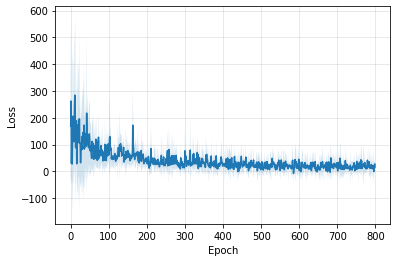

In [23]:
steps = np.arange(n_epochs)
plt.plot(steps, history["loss-mu"])

plt.fill_between(steps, history["loss-mu"]-history["loss-std"], 
                 history["loss-mu"]+history["loss-std"], alpha=0.2)
plt.grid(alpha=0.35)
plt.xlabel("Epoch")
plt.ylabel("Loss")

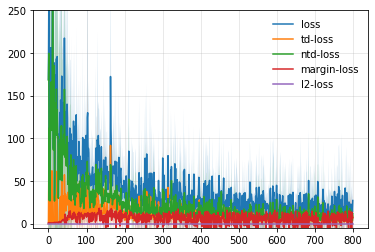

In [24]:
for loggable in loggables:
    plt.plot(steps, history[loggable + "-mu"], label=loggable)
    plt.fill_between(steps, history[loggable + "-mu"] - history[loggable + "-std"],
                     history[loggable + "-mu"] + history[loggable + "-std"],
                     alpha=0.2
                    )
plt.grid(alpha=0.35)
plt.ylim([-5, 250])
plt.legend(frameon=False)

In [25]:
env = retro.make('SonicTheHedgehog-Genesis', state=config['level'])
utils.play_evaluation_games(env, online_model, 
                      state_transformer=utils.torchify_state, 
                      action_transformer=lambda x: utils.decoding_action_transformer(x, decoding),
                      n_games=10, rnd_steps=50, max_frames=1000)

Finished game 0 with score    100.
Finished game 1 with score    100.
Finished game 2 with score    100.
Finished game 3 with score      0.
Finished game 4 with score    100.
Finished game 5 with score      0.
Finished game 6 with score      0.
Finished game 7 with score    100.
Finished game 8 with score    100.
Finished game 9 with score      0.


[100.0, 100.0, 100.0, 0.0, 100.0, 0.0, 0.0, 100.0, 100.0, 0.0]

In [26]:
frames = utils.record_imitation_game(env=env, model=online_model, 
                               action_transformer=lambda x: utils.decoding_action_transformer(x, decoding),
                               state_transformer=utils.torchify_state,
                               rnd_steps=50, max_frames=5000)

Collected 100 frames
Collected 200 frames
Collected 300 frames
Collected 400 frames
Collected 500 frames
Collected 600 frames
Collected 700 frames
Collected 800 frames
Collected 900 frames
Collected 1000 frames
Collected 1100 frames
Collected 1200 frames
Collected 1300 frames
Collected 1400 frames
Collected 1500 frames
Collected 1600 frames
Collected 1700 frames
Collected 1800 frames
Collected 1900 frames
Collected 2000 frames
Collected 2100 frames
Collected 2200 frames
Collected 2300 frames
Collected 2400 frames
Collected 2500 frames
Collected 2600 frames
Collected 2700 frames
Collected 2800 frames
Collected 2900 frames
Collected 3000 frames
Collected 3100 frames
Collected 3200 frames
Collected 3300 frames
Collected 3400 frames
Collected 3500 frames
Collected 3600 frames
Collected 3700 frames
Collected 3800 frames
Collected 3900 frames
Collected 4000 frames
Collected 4100 frames
Collected 4200 frames
Collected 4300 frames
Collected 4400 frames
Collected 4500 frames
Collected 4600 fram

In [27]:
imageio.mimwrite(
    "torch_dqfd_agent_{}.mp4".format(config["level"]), 
    frames, fps=30)

In [28]:
class PrioritizedReplayBuffer:
    
    """ Prioritized replay buffer following the RL-Adventure example
    and the paper but written in my own style. """
    
    def __init__(self, maxsize, alpha=0.6):
        self.maxsize = maxsize
        self.alpha = alpha
        self.priorities, self.buffer = [], []
        self.last_batch_indices = None
        
    def add(self, transition):
        """ Add to the buffer and ensure that it is 
        not too full. """

        max_prio = np.max(self.priorities) if self.buffer else 1.0
        
        self.buffer.append(transition)
        self.priorities.append(max_prio)
        
        if len(self.buffer) > self.maxsize:
            self.buffer.pop(0)
            self.priorities.pop(0)
            
            
    def sample(self, batch_size, beta=0.4):
        """ Get a batch of transitions. """
        probs = np.array(self.priorities) ** self.alpha
        probs /= np.sum(probs)
        self.last_batch_indices = np.random.choice(np.arange(len(self.buffer)), batch_size, p=probs)
        total = len(self.buffer)
        return [(self.buffer[idx], (probs[idx] * total) ** -beta) for idx in self.last_batch_indices]


    def update_priorities(self, prios):
        if self.last_batch_indices is not None:
            for index, prio in zip(self.last_batch_indices, prios):
                self.priorities[index] = prio

In [29]:
from collections import namedtuple

In [30]:
Transition = namedtuple('Transition', 'state action next_state nth_state reward discounted_reward done')

In [31]:
def convert_to_transition(states, actions, next_states, nth_states, rewards, discounted_rewards, dones):
    """ Convert lists of state-actions to transitions. """
    
    transitions = []
    for index in range(len(states)):
        transition = Transition(
            state=states[index], action=actions[index], next_state=next_states[index],
            nth_state=nth_states[index], reward=rewards[index], discounted_reward=discounted_rewards[index],
            done=dones[index]
        )
        transitions.append(transition)
        
    return transitions

In [32]:
transitions = convert_to_transition(
    states=_states, actions=_actions, next_states=_next_states,
    nth_states=_nth_states, rewards=_rewards, discounted_rewards=_discounted_rewards,
    dones=_dones
)

In [33]:
buffer = PrioritizedReplayBuffer(maxsize=4000, alpha=0.6)

for transition in transitions:
    buffer.add(transition)
    
del transitions

In [34]:
long_it = lambda x: utils.torchify_long(x).to(device='cuda:0')
float_it = lambda x: utils.torchify_float(x).to(device='cuda:0')

In [35]:
def torch_weighted_td_loss(online_model, target_model, states, actions, 
                  next_states, rewards, dones, weights, gamma=0.99):
    """ Compute the weighted TD-error using pytorch for a set of transitions.  Return
        the full loss so that we can calculate the priorities.
    """
    
    # Predict the value of the current and next state using the 
    # online and target networks respectively. 
    q_values = online_model(states)
    next_q_values = target_model(next_states)
    
    # Mask those states for which the next state is terminal.
    q_values = q_values.gather(1, actions.view(-1,1)).squeeze(1)
    next_q_values = next_q_values.max(1).values

    qhat = (rewards + gamma * next_q_values * (1 - dones))
    loss = (q_values - qhat.detach()).pow(2) * weights
    return loss


def torch_dqfd_loss(online_model, target_model, states, next_states, nth_states, 
                    rewards, discounted_rewards, dones, weights, gamma, n, coef1, coef2, coef3,
                    margin, expert_actions
                   ):
    """ Construct the full DQfD loss from the four component loss functions.
    """
    
    # Predict which action to take from the online network.
    q_values = online_model(states)
    actions = torch.argmax(q_values, axis=1)
    
    td_loss = torch_weighted_td_loss(
        online_model=online_model, 
        target_model=target_model, 
        actions=actions, states=states, 
        next_states=next_states, rewards=rewards,
        weights=weights, dones=dones, gamma=gamma)
    
    ntd_loss = torch_nstep_td_loss(
        online_model=online_model, target_model=target_model, 
        actions=actions, states=states, 
        nth_states=nth_states, 
        discounted_rewards=discounted_rewards, 
        dones=dones, gamma=gamma, n=n)
    
    q_values = online_model(states)
    margin_loss = torch_margin_loss(q_values, expert_actions, margin)
    margin_loss = torch.mean(margin_loss)
    l2_loss = torch_l2_penalty(online_model.parameters())
    
    loss = td_loss + coef1 * ntd_loss + coef2 * margin_loss + coef3 * l2_loss
    
    return loss, td_loss, ntd_loss * coef1, margin_loss * coef2, l2_loss * coef3

In [36]:
"""
online_model = online_model.to(device='cuda:0')
target_model = target_model.to(device='cuda:0')
target_model.load_state_dict(online_model.state_dict())
optimizer = optim.Adam(online_model.parameters(), lr=1e-4)

history = {}
loggables = ["loss", "td-loss", "ntd-loss", "margin-loss", "l2-loss"]
for loggable in loggables:
    history[loggable + "-mu"] = np.zeros(n_epochs)
    history[loggable + "-std"] = np.zeros(n_epochs)
    
for epoch in range(n_epochs):
    
    if epoch % config['update_freq'] == 0:
        target_model.load_state_dict(online_model.state_dict())
    
    epoch_loss = []
    epoch_td_loss, epoch_ntd_loss, epoch_margin_loss, epoch_l2_loss = [], [], [], []
    for batch in range(n_batches_per_epoch):
        
        # Generate a batch of transitions from the buffer.
        b_actions, b_states, b_next_states = [], [], []
        b_nth_states, b_rewards, b_discounted_rewards = [], [], []
        b_dones, b_weights = [], []
        for transition, weight in buffer.sample(batch_size):
            b_actions.append(transition.action)
            b_states.append(transition.state)
            b_next_states.append(transition.next_state)
            b_nth_states.append(transition.nth_state)
            b_rewards.append(transition.reward)
            b_discounted_rewards.append(transition.discounted_reward)
            b_dones.append(transition.done)
            b_weights.append(weight)
        
        # Cast the transition components to torch tensors.
        b_actions = long_it(b_actions)
        b_states = float_it(b_states)
        b_next_states = float_it(b_next_states)
        b_nth_states = float_it(b_nth_states)
        b_rewards = float_it(b_rewards)
        b_discounted_rewards = float_it(b_discounted_rewards)
        b_dones = float_it(b_dones)
        b_weights = float_it(b_weights)
        
        optimizer.zero_grad()
        q_values = online_model(b_states)
        actions = torch.argmax(q_values, axis=1)
    
        td_loss = torch_weighted_td_loss(
            online_model=online_model, 
            target_model=target_model, 
            actions=b_actions, states=b_states, 
            next_states=b_next_states, rewards=b_rewards,
            weights=b_weights, dones=b_dones, gamma=config['gamma'])
        
        td_error = td_loss.detach().cpu().numpy() + 1e-5
        buffer.update_priorities(td_error)
        td_loss = torch.mean(td_loss)
        
        ntd_loss = torch_nstep_td_loss(
            online_model=online_model, target_model=target_model, 
            actions=b_actions, states=b_states, 
            nth_states=b_nth_states, 
            discounted_rewards=b_discounted_rewards, 
            dones=b_dones, gamma=config['gamma'], n=config['n_steps'])

        q_values = online_model(b_states)
        margin_loss = torch_margin_loss(q_values, b_actions, config['margin'])
        margin_loss = torch.mean(margin_loss)
        l2_loss = torch_l2_penalty(online_model.parameters())

        loss = td_loss + config['coef1'] * ntd_loss + config['coef2'] * margin_loss + config['coef3'] * l2_loss

        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.detach().cpu().numpy())
        epoch_td_loss.append(td_loss.detach().cpu().numpy())
        epoch_ntd_loss.append(ntd_loss.detach().cpu().numpy())
        epoch_margin_loss.append(margin_loss.detach().cpu().numpy())
        epoch_l2_loss.append(l2_loss.detach().cpu().numpy())
        
    print("Epoch {0}, Loss {1:6.4f}, TD-Loss {2:6.4f}, NTD-Loss {3:6.4f}, Margin Loss {4:6.4f}, L2 Loss {5:6.4f}".format(
        epoch, np.mean(epoch_loss), np.mean(epoch_td_loss), 
        np.mean(epoch_ntd_loss), np.mean(epoch_margin_loss), np.mean(epoch_l2_loss))
         )
    
    history["loss-mu"][epoch] = np.mean(epoch_loss)
    history["loss-std"][epoch] = np.std(epoch_loss)
    history["td-loss-mu"][epoch] = np.mean(epoch_td_loss)
    history["td-loss-std"][epoch] = np.std(epoch_td_loss)
    history["ntd-loss-mu"][epoch] = np.mean(epoch_ntd_loss)
    history["ntd-loss-std"][epoch] = np.std(epoch_ntd_loss)
    history["margin-loss-mu"][epoch] = np.mean(epoch_margin_loss)
    history["margin-loss-std"][epoch] = np.std(epoch_margin_loss)
    history["l2-loss-mu"][epoch] = np.mean(epoch_l2_loss)
    history["l2-loss-std"][epoch] = np.std(epoch_l2_loss)    
"""

'\nonline_model = online_model.to(device=\'cuda:0\')\ntarget_model = target_model.to(device=\'cuda:0\')\ntarget_model.load_state_dict(online_model.state_dict())\noptimizer = optim.Adam(online_model.parameters(), lr=1e-4)\n\nhistory = {}\nloggables = ["loss", "td-loss", "ntd-loss", "margin-loss", "l2-loss"]\nfor loggable in loggables:\n    history[loggable + "-mu"] = np.zeros(n_epochs)\n    history[loggable + "-std"] = np.zeros(n_epochs)\n    \nfor epoch in range(n_epochs):\n    \n    if epoch % config[\'update_freq\'] == 0:\n        target_model.load_state_dict(online_model.state_dict())\n    \n    epoch_loss = []\n    epoch_td_loss, epoch_ntd_loss, epoch_margin_loss, epoch_l2_loss = [], [], [], []\n    for batch in range(n_batches_per_epoch):\n        \n        # Generate a batch of transitions from the buffer.\n        b_actions, b_states, b_next_states = [], [], []\n        b_nth_states, b_rewards, b_discounted_rewards = [], [], []\n        b_dones, b_weights = [], []\n        for t